# Auto encoder
This notebook demonstrates a simple auto encoder.

## First I define some utility functions
This functions can mostly be ignored and are included simply from necessity

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import typing
import utils

In [2]:
def visualize_model(encoder, decoder, X_val):
    val_size = X_val.shape[0]
    j = np.random.randint(0,val_size - 5)
    z = encode.forward(X_val)
    y = decode.forward(z)
    for i in range(0,5):
        plt.subplot(1,2,1)
        plt.imshow(X_val[j + i,1:].reshape(28,28), cmap="gray")
        plt.subplot(1,2,2)
        plt.imshow(y[j + i,1:].reshape(28,28), cmap="gray")
        plt.show()

In [3]:
def calculate_loss(x, y):
    loss = np.sum(0.5*(x-y)**2)
    print(f"Validation loss: {loss}")
    return loss

In [4]:
def pre_process_images(X: np.ndarray, mean: float = 33.3, std: float = 78.5):
    """
    Args:
        X: images of shape [batch size, 784] in the range (0, 255)
    Returns:
        X: images of shape [batch size, 785]
    """
    
    X = (X-mean)/std
    
    assert X.shape[1] == 784,\
        f"X.shape[1]: {X.shape[1]}, should be 784"
    
    newArr = np.ones((X.shape[0],785))
    newArr[:,1:] = X
    assert newArr.shape == (X.shape[0], 785),\
        f"Pre processed shape: {newArr.shape}"
    return newArr


## Model definitions
Here I define an encoder and a decoder. As they are both more or less identical FCNN I let the decoder inherit most of the encoders functions. The only difference is that the encoder receives its first delta from the encoder, whereas the decoder receives the first delta from an l2-loss function

In [5]:
class EncodeModel:

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,
                 use_improved_weight_init: bool  
                 ):
        # Define number of input nodes
        self.I = neurons_per_layer[0]
        self.use_improved_sigmoid = use_improved_sigmoid
        print(f"\n\nInitializing with improved sigmoid: {use_improved_sigmoid}")
        print(f"Initializing with improved weight init: {use_improved_weight_init}")

        self.neurons_per_layer = neurons_per_layer[1:]
        
        # Initialize the weights
        self.ws = []
        prev = self.I
        for size in self.neurons_per_layer:
            w_shape = (prev, size)
            print("Initializing weight to shape:", w_shape)
            if(use_improved_weight_init):
                w = np.random.normal(0, 1/np.sqrt(prev), w_shape)
            else:
                w = np.random.uniform(-1, 1, w_shape)
            self.ws.append(w)
            prev = size
        self.grads = [None for i in range(len(self.ws))]
        #Needed for backpropagation
        self.intermediates = []
        #Needed for improved sigmoid backpropagation
        self.z = []

    def forward(self, X: np.ndarray) -> np.ndarray:
        """
        Args:
            X: images of shape [batch size, 785]
        Returns:
            y: output of model with shape [batch size, num_outputs]
        """

        assert X.shape[1] == self.ws[0].shape[0], \
            f"X shape: {X.shape}, weight shape: {self.ws[0].shape}"
        self.intermediates = []
        self.z = []
        self.intermediates.append(X)
        #Functionality for multiple layers for task 4c
        for i in range(0, len(self.ws)-1):
            self.z.append(self.intermediates[-1] @ self.ws[i])
            if(self.use_improved_sigmoid):
                self.intermediates.append(1.7159*np.tanh(2*self.z[-1]/3))
            else:
                self.intermediates.append(1/(1 + np.exp(- self.z[-1])))
        
        z2 = self.intermediates[-1] @ self.ws[-1] 
        #exponent = np.exp(z2)
        #exponent /= exponent.sum(axis = 1, keepdims = True)        
        #assert exponent.shape == (X.shape[0],10),\
         #   f"Shape after forward pass is wrong"
        return z2

    def backward(self, X: np.ndarray, delta):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: outputs of model of shape: [batch size, num_outputs]
            targets: labels/targets of each image of shape: [batch size, num_classes]
        """
        batchSize = X.shape[0]
        #assert targets.shape == outputs.shape,\
        #    f"Output shape: {outputs.shape}, targets: {targets.shape}"
        # A list of gradients.
        # For example, self.grads[0] will be the gradient for the first hidden layer
        self.grads = []
        outputGrad = self.intermediates[-1].transpose() @ delta / batchSize
        self.grads.append(outputGrad)
        
        #Generalization to multiple layers
        for i in range(1,len(self.ws)):
            Q = delta @ self.ws[-i].transpose()
            if(self.use_improved_sigmoid):
                sigmoidDerivative = 2.28786/(np.cosh(4*self.z[-i]/3) + 1)
            else:
                sigmoidDerivative = (self.intermediates[-i]*(1-self.intermediates[-i]))
            delta = sigmoidDerivative * Q
            
            hiddenGrad = self.intermediates[-i-1].transpose() @ delta / batchSize
            self.grads.append(hiddenGrad)
            
        self.grads.reverse()
        Q = delta @ self.ws[0].transpose()   
        for grad, w in zip(self.grads, self.ws):
            assert grad.shape == w.shape,\
                f"Expected the same shape. Grad shape: {grad.shape}, w: {w.shape}."
        return Q

    def zero_grad(self) -> None:
        self.grads = [None for i in range(len(self.ws))]


In [6]:
class DecodeModel(EncodeModel):

    def __init__(self,
                 # Number of neurons per layer
                 neurons_per_layer: typing.List[int],
                 use_improved_sigmoid: bool,  # Task 3a hyperparameter
                 use_improved_weight_init: bool  # Task 3c hyperparameter
                 ):
        super().__init__(neurons_per_layer, use_improved_sigmoid, use_improved_weight_init)
    def backward(self, X: np.ndarray, outputs):
        """
        Args:
            X: images of shape [batch size, 785]
            outputs: Reconstructed images of shape [batch size, 785]
        """
        batchSize = X.shape[0]
        assert X.shape == outputs.shape,\
            f"Output shape: {outputs.shape}, targets: {X.shape}"
        # A list of gradients.
        # For example, self.grads[0] will be the gradient for the first hidden layer
        self.grads = []
        delta = (outputs - X)
        return super().backward(X, delta)

## Putting everything together for auto encoder
Here I define a training function for training on mnist data. I combine the encoder and decoder into an unsuperised auto encoder.

The encoder outputs a vector z. This is called the latent-space, and is a low dimentional mapping of x. In this example I relatively successfully reduce the 784 dimentional image into a 5 dimentional lantent space.

The 5 dimentional latent-space vector is then passed through the decoder to try to recreate the original image. 

In [7]:
def train_mnist(encoder, decoder, num_epochs):
    validation_percentage = 0.1
    X_train, Y_train, X_val, Y_val, X_test, Y_test = utils.load_full_mnist(
        validation_percentage)
    val_size = X_val.shape[0]
    print(f"Validation percentage: {validation_percentage}, gives validation size: {val_size}")
    mean = np.mean(X_train)
    std = np.std(X_train)
    X_train = pre_process_images(X_train, mean, std)
    X_val = pre_process_images(X_val, mean, std)
    
    
    val_loss = {}
    
    batch_size = 16
    num_batches_per_epoch = X_train.shape[0] // batch_size
    num_steps_per_viz = num_batches_per_epoch*2
    num_steps_per_val = num_batches_per_epoch // 5
    lr = 0.01
    global_step = 0
    for epoch in range(num_epochs):
            print("Starting epoch: ", epoch)
            for step in range(num_batches_per_epoch):
                start = step * batch_size
                end = start + batch_size
                x = X_train[start:end]

                encode.zero_grad()
                decode.zero_grad()
                z = encode.forward(x)
                y = decode.forward(z)
                delta = decode.backward(x, y)
                encode.backward(z, delta)
                for w, grad in zip(decode.ws, decode.grads):
                    w -= lr*grad
                for w, grad in zip(encode.ws, encode.grads):
                    w -= lr*grad


                # Track train / validation loss / accuracy
                # every time we progress 20% through the dataset
                if (global_step % num_steps_per_val) == 0:
                    z = encoder.forward(X_val)
                    y = decoder.forward(z)
                    val_loss[global_step] = calculate_loss(X_val,y)
                    
                if (global_step % num_steps_per_viz) == 0:
                    visualize_model(encoder, decoder, X_val)
                global_step += 1

    return val_loss



Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (785, 100)
Initializing weight to shape: (100, 50)
Initializing weight to shape: (50, 5)


Initializing with improved sigmoid: False
Initializing with improved weight init: True
Initializing weight to shape: (5, 50)
Initializing weight to shape: (50, 100)
Initializing weight to shape: (100, 785)
Train shape: X: (54000, 784), Y: (54000, 1)
Validation shape: X: (6000, 784), Y: (6000, 1)
Test shape: X: (10000, 784), Y: (10000, 1)
Validation percentage: 0.1, gives validation size: 6000
Starting epoch:  0
Validation loss: 2339527.8688978245


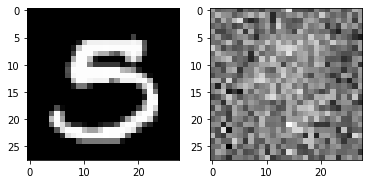

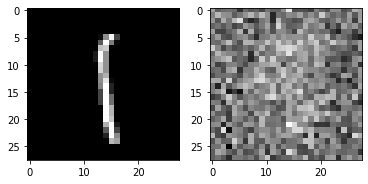

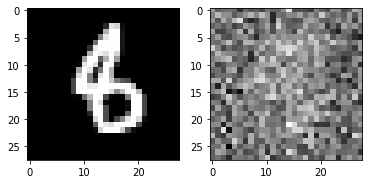

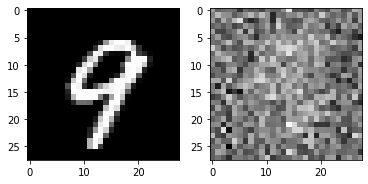

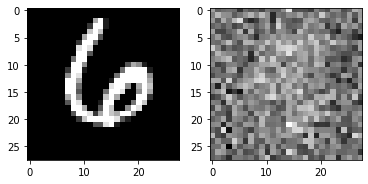

Validation loss: 1386961.4032935281
Validation loss: 1146455.1711006323
Validation loss: 1072541.28350259
Validation loss: 1008272.0665156491
Starting epoch:  1
Validation loss: 961996.1944535405
Validation loss: 929726.1290968928
Validation loss: 905127.5053792283
Validation loss: 879073.7842464496
Validation loss: 865204.2795038546
Starting epoch:  2
Validation loss: 849116.6479659515


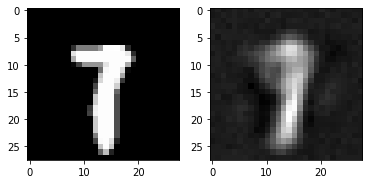

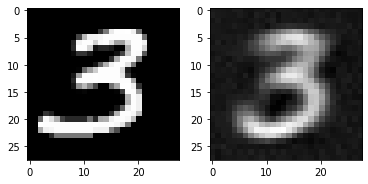

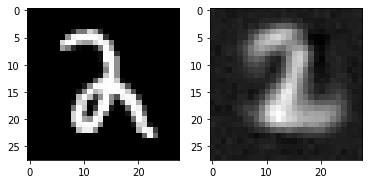

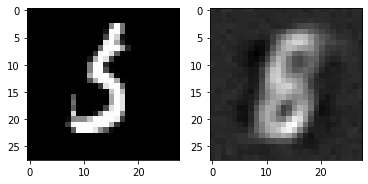

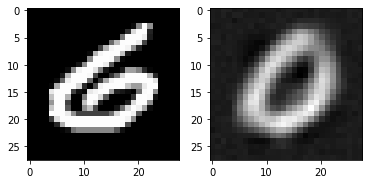

Validation loss: 842836.3861716972
Validation loss: 828890.747954721
Validation loss: 817833.4891958314
Validation loss: 813211.6471104593
Starting epoch:  3
Validation loss: 807259.3196010579
Validation loss: 800100.3044663569
Validation loss: 790484.9867500259
Validation loss: 787921.338128103
Validation loss: 781426.8143878228
Starting epoch:  4
Validation loss: 780378.5707283576


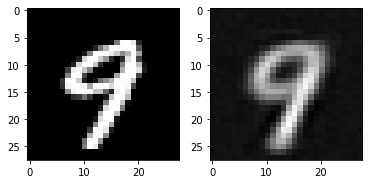

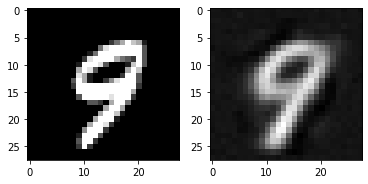

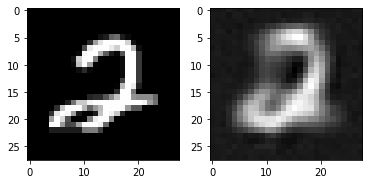

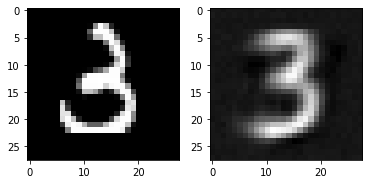

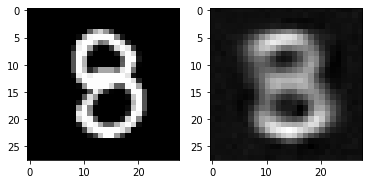

Validation loss: 772239.58851874
Validation loss: 768693.960794305
Validation loss: 770878.5320494646
Validation loss: 759782.7082646505
Starting epoch:  5
Validation loss: 763681.6533444773
Validation loss: 754793.412832109
Validation loss: 752543.3719219232
Validation loss: 752886.0839875838
Validation loss: 746922.0526834056
Starting epoch:  6
Validation loss: 753815.2817361461


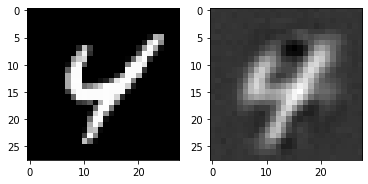

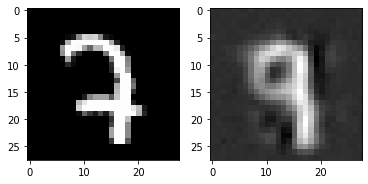

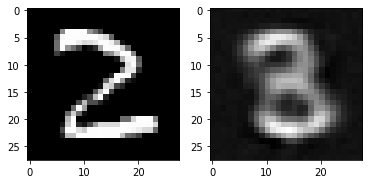

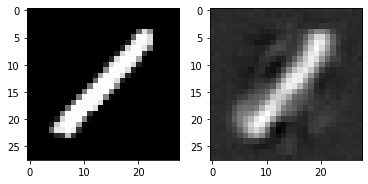

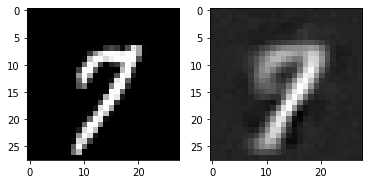

Validation loss: 743149.0884841018
Validation loss: 740665.645027613
Validation loss: 740527.851129225
Validation loss: 737376.4643138355
Starting epoch:  7
Validation loss: 738381.3704768952
Validation loss: 734355.175190235
Validation loss: 732497.3561315804
Validation loss: 731419.7271314561
Validation loss: 729170.1498101247
Starting epoch:  8
Validation loss: 733393.6938262847


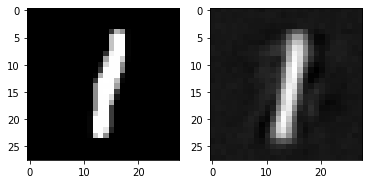

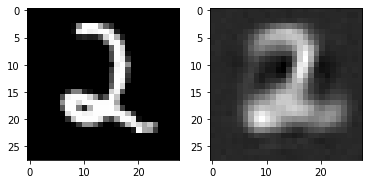

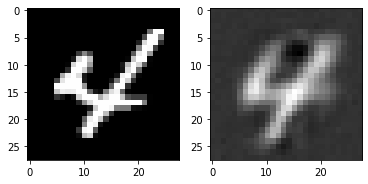

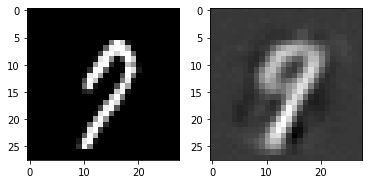

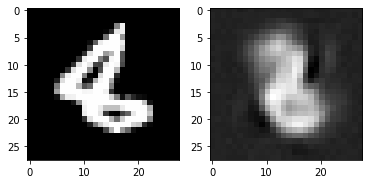

Validation loss: 724844.0405089103
Validation loss: 729186.0520456933
Validation loss: 723647.6252775366
Validation loss: 722300.8188716099
Starting epoch:  9
Validation loss: 726251.5640295104
Validation loss: 721979.122051555
Validation loss: 723144.0796861832
Validation loss: 722518.0208948312
Validation loss: 718921.7451304802
Starting epoch:  10
Validation loss: 719535.8301274071


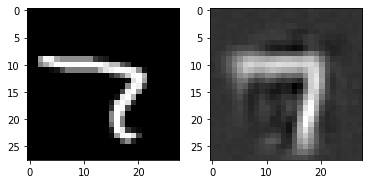

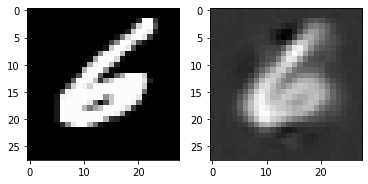

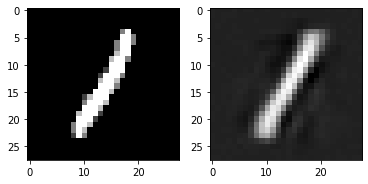

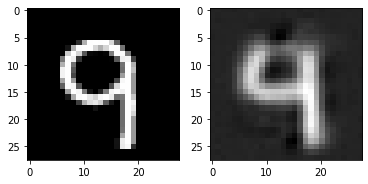

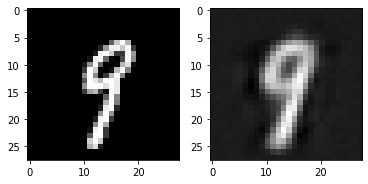

Validation loss: 716840.9749118084
Validation loss: 715916.1833900675
Validation loss: 713672.0260975612
Validation loss: 711839.9104847121
Starting epoch:  11
Validation loss: 714083.8259371009
Validation loss: 711276.402439812
Validation loss: 711265.3163154451
Validation loss: 711075.7249568675
Validation loss: 707941.6007317171
Starting epoch:  12
Validation loss: 711065.1689097049


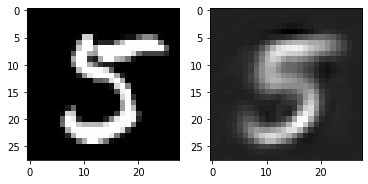

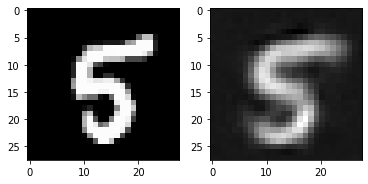

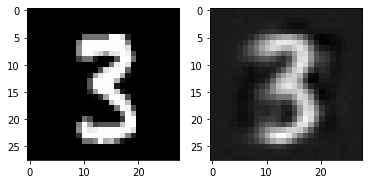

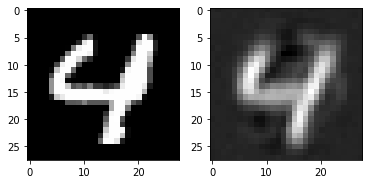

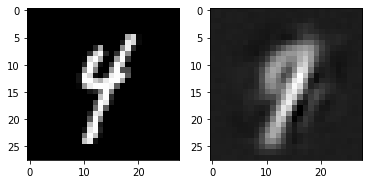

Validation loss: 706372.1946557057
Validation loss: 714941.8062073542
Validation loss: 705743.6586323438
Validation loss: 706315.1595591691
Starting epoch:  13
Validation loss: 707801.4213341528
Validation loss: 703706.5427401252
Validation loss: 710397.6382757205
Validation loss: 703716.5942323762
Validation loss: 705948.0043000542
Starting epoch:  14
Validation loss: 707999.9410947824


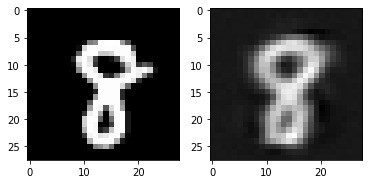

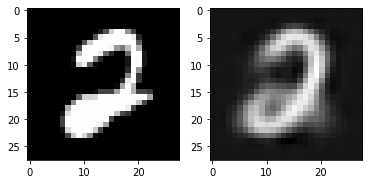

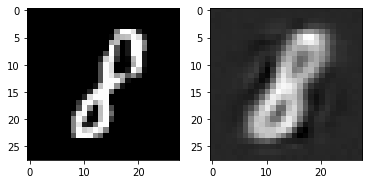

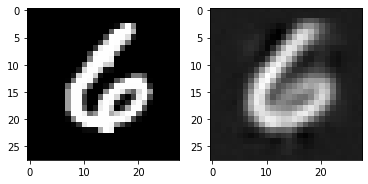

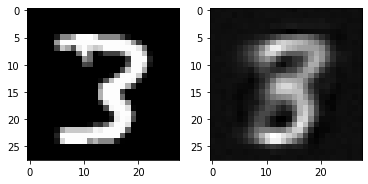

Validation loss: 701223.4015934734
Validation loss: 712775.8910688846
Validation loss: 700027.6391341116
Validation loss: 701983.3016325164
Starting epoch:  15
Validation loss: 704670.345498358
Validation loss: 700843.4885569757
Validation loss: 708970.1110779971
Validation loss: 699181.8036094682
Validation loss: 699374.0783938263
Starting epoch:  16
Validation loss: 700415.18592182


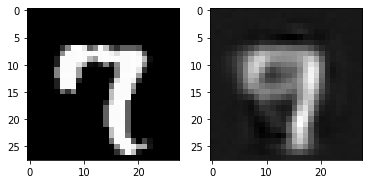

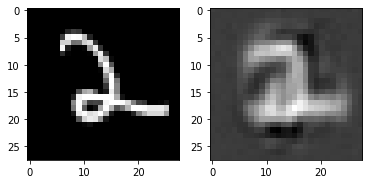

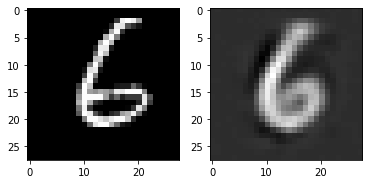

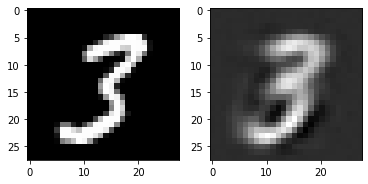

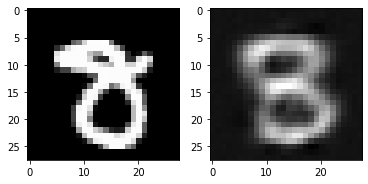

Validation loss: 699308.5602128039
Validation loss: 705405.2303232868
Validation loss: 696926.9481378851
Validation loss: 698891.6258096475
Starting epoch:  17
Validation loss: 697451.8868078381
Validation loss: 696630.4481027004
Validation loss: 699849.1806127557
Validation loss: 697801.7219348174
Validation loss: 697762.183416741
Starting epoch:  18
Validation loss: 693796.89040206


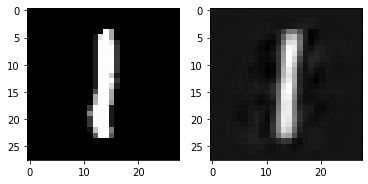

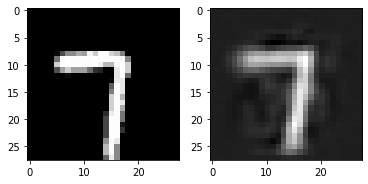

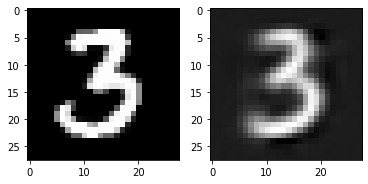

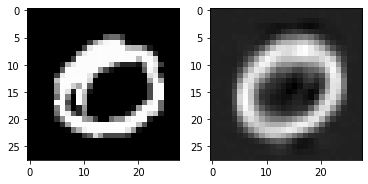

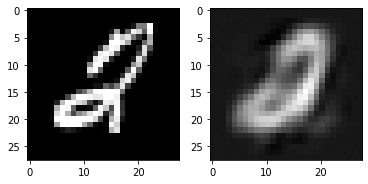

Validation loss: 694189.5031517714
Validation loss: 701679.3988462258
Validation loss: 698387.9355704599
Validation loss: 695774.5608191207
Starting epoch:  19
Validation loss: 693919.8305804709
Validation loss: 695710.6543669618
Validation loss: 696150.6488249182
Validation loss: 694498.1761238141
Validation loss: 691569.7337385381
Starting epoch:  20
Validation loss: 691892.5190812624


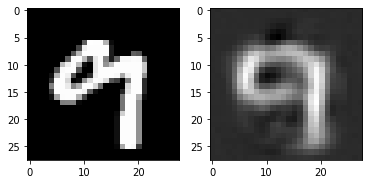

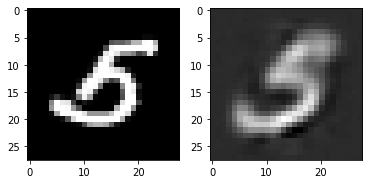

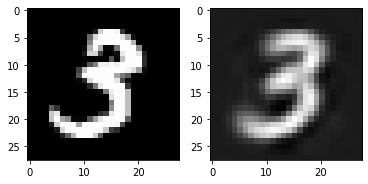

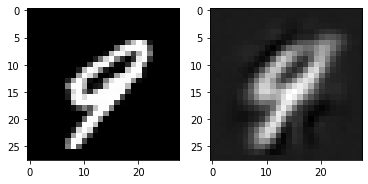

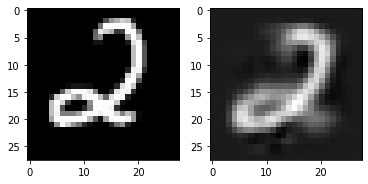

Validation loss: 693225.4603890718
Validation loss: 700122.3523191203
Validation loss: 698065.1222736866
Validation loss: 693945.4590585043
Starting epoch:  21
Validation loss: 689078.1672641907
Validation loss: 692800.880145596
Validation loss: 699442.6043459103
Validation loss: 694883.635123646
Validation loss: 690975.7924789854
Starting epoch:  22
Validation loss: 689379.5543884734


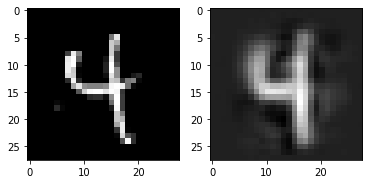

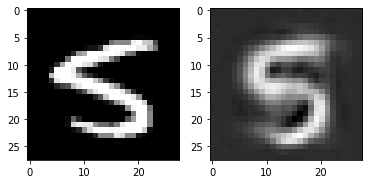

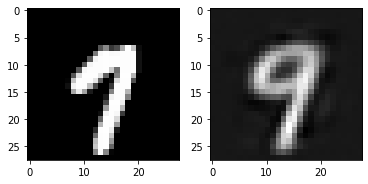

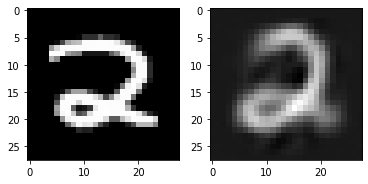

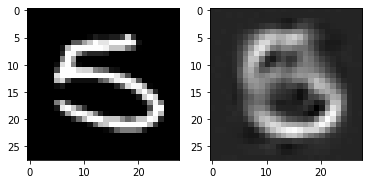

Validation loss: 693399.167426786
Validation loss: 696473.8604668394
Validation loss: 694572.696801469
Validation loss: 690842.4347307337
Starting epoch:  23
Validation loss: 688534.2636445088
Validation loss: 691844.1501238522
Validation loss: 694706.4845986648
Validation loss: 693172.7581447972
Validation loss: 690392.0543373785
Starting epoch:  24
Validation loss: 690593.4282632705


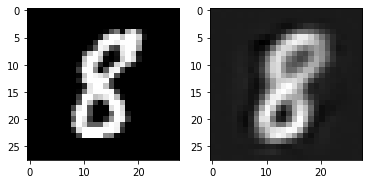

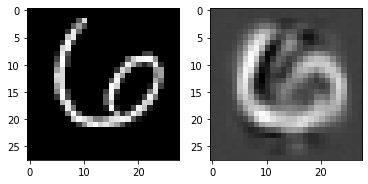

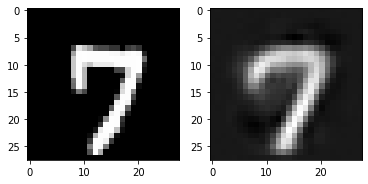

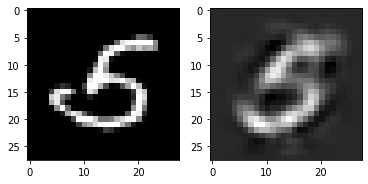

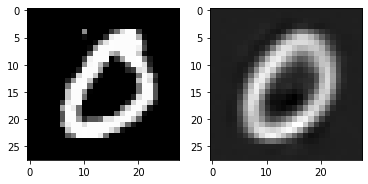

Validation loss: 690301.2594197358
Validation loss: 696120.4798820266
Validation loss: 691644.8120886032
Validation loss: 688423.6414108265
Starting epoch:  25
Validation loss: 689460.2941742865
Validation loss: 691883.1266428916
Validation loss: 691045.1401007323
Validation loss: 689845.7937108374
Validation loss: 687785.0586271635
Starting epoch:  26
Validation loss: 691002.4065465818


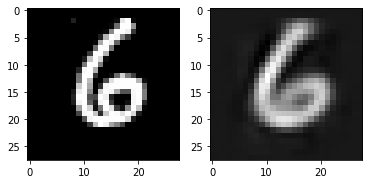

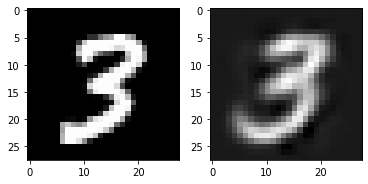

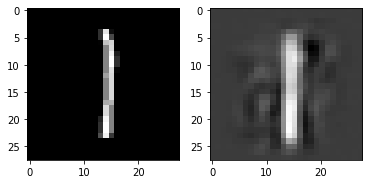

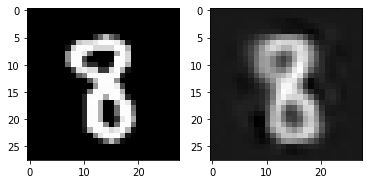

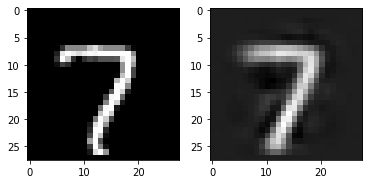

Validation loss: 690971.0207782075
Validation loss: 691473.7539031064
Validation loss: 691187.975714696
Validation loss: 688115.3588699541
Starting epoch:  27
Validation loss: 689348.8788950352
Validation loss: 690080.9959394801
Validation loss: 691510.3122082
Validation loss: 688058.8527926905
Validation loss: 688582.8106448656
Starting epoch:  28
Validation loss: 689282.6075574484


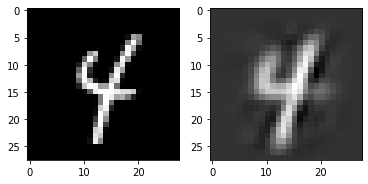

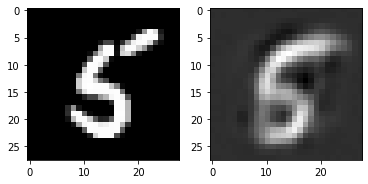

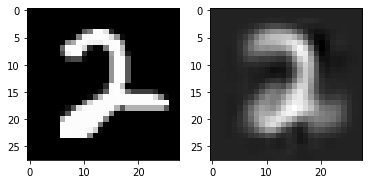

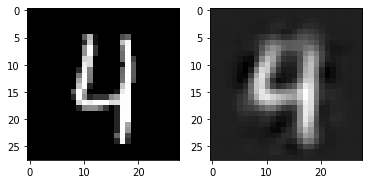

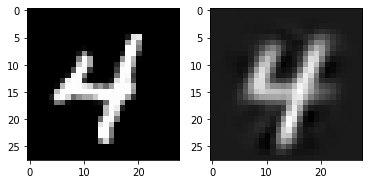

Validation loss: 691454.6203727832
Validation loss: 689658.1331764904
Validation loss: 688250.9409667278
Validation loss: 687624.4393083802
Starting epoch:  29
Validation loss: 689419.9138696351
Validation loss: 688223.1024515065
Validation loss: 690085.4492970515
Validation loss: 686651.1481832846
Validation loss: 687249.760933486


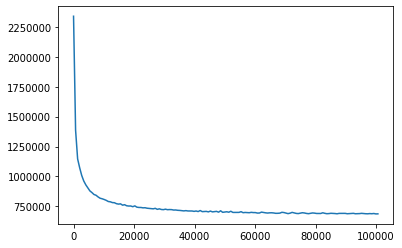

In [8]:
encode = EncodeModel([785,100,50,5], False, True)
decode = DecodeModel([5,50, 100, 785],False, True)
val_loss = train_mnist(encode, decode, 30)
utils.plot_loss(val_loss, "Validation loss")

## Sampling
Sampling is not really possible in the simple auto encoder as it is not stochastic in nature. The see the notebook on variational auto encoder instead.